AI MODEL TRAIN NOTEBOOK WITH SPOTIFY AUDIO FEATURES

In [16]:
import pandas as pd
import json
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load audio features from JSON file
with open('audio_features.json') as file:  # Replace 'audio_features.json' with the actual file name
    data = json.load(file)

# Convert JSON data to DataFrame
df_audio_features = pd.DataFrame(data)

# Display the first few rows to confirm it loaded correctly
print(df_audio_features.head())

                 track_id  acousticness  danceability  energy  \
0  34KTEhpPjq6IAgQg2yzJAL        0.0021         0.592   0.767   
1  1og0kGjsNTWB5gnVcxbqb3        0.8420         0.542   0.303   
2  7eLCcnhpYGH3Y6Pqrk68Gz        0.0320         0.657   0.611   
3  0uexBOVPB278fGFOxOUosN        0.3120         0.781   0.877   
4  0NRdCItA8w9eB7MOcprHVi        0.6540         0.625   0.351   

   instrumentalness  liveness  loudness  speechiness  valence       tempo  \
0           0.00165    0.1270    -2.788       0.0270    0.328   96.483002   
1           0.00000    0.0853   -10.229       0.0293    0.231  115.194000   
2           0.00000    0.4690    -7.899       0.4910    0.408  140.151001   
3           0.00000    0.3700    -5.761       0.0377    0.781  108.066002   
4           0.37100    0.1960   -13.338       0.0489    0.205  115.495003   

   track_key  mode  time_signature  
0          9     0               4  
1          7     1               4  
2          1     1               5 

In [17]:
print(len(df_audio_features))

10000


In [19]:
# Generate sample mood labels to match the DataFrame length
# Relevant features for mood classification
features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]
X = df_audio_features[features]

moods = ['happy', 'sad', 'energetic', 'calm']
df_audio_features['mood'] = [moods[i % len(moods)] for i in range(len(df_audio_features))]

X = df_audio_features.select_dtypes(include=['number'])

# If you have a 'mood' column as your target variable, separate it
y = df_audio_features['mood'] if 'mood' in df_audio_features.columns else None

# Check the resulting DataFrame
print(X.head())

   acousticness  danceability  energy  instrumentalness  liveness  loudness  \
0        0.0021         0.592   0.767           0.00165    0.1270    -2.788   
1        0.8420         0.542   0.303           0.00000    0.0853   -10.229   
2        0.0320         0.657   0.611           0.00000    0.4690    -7.899   
3        0.3120         0.781   0.877           0.00000    0.3700    -5.761   
4        0.6540         0.625   0.351           0.37100    0.1960   -13.338   

   speechiness  valence       tempo  track_key  mode  time_signature  
0       0.0270    0.328   96.483002          9     0               4  
1       0.0293    0.231  115.194000          7     1               4  
2       0.4910    0.408  140.151001          1     1               5  
3       0.0377    0.781  108.066002          2     0               4  
4       0.0489    0.205  115.495003          1     0               4  


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Ensure X contains only the relevant numeric features

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [45]:
param_grid = {
    'n_neighbors': [50, 100, 200],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [50, 100, 200],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [46]:
best_k = grid_search.best_params_['n_neighbors']
print(f"Best number of neighbors (k): {best_k}")

Best number of neighbors (k): 50


In [47]:
best_knn_model = KNeighborsClassifier(n_neighbors=best_k, weights='distance', metric='manhattan')
best_knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=50, weights='distance')

In [48]:
y_pred = best_knn_model.predict(X_test)

In [49]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.259
Classification Report:
               precision    recall  f1-score   support

        calm       0.25      0.25      0.25       497
   energetic       0.25      0.20      0.22       527
       happy       0.26      0.28      0.27       480
         sad       0.28      0.31      0.29       496

    accuracy                           0.26      2000
   macro avg       0.26      0.26      0.26      2000
weighted avg       0.26      0.26      0.26      2000



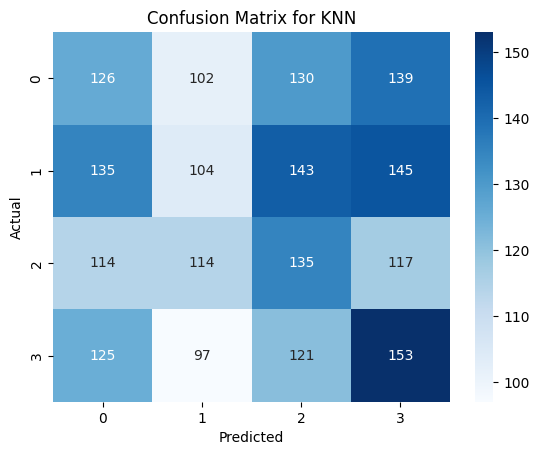

In [50]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN')
plt.show()